In [ ]:
# Install required libaries
!pip install tweepy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install numpy
!pip install gensim
!pip install seaborn
!pip install bokeh
!pip install pyldavis==2.1.2
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem.porter import *
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import os.path
import tweepy
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import nltk
import spacy
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Questions we are looking to answer about the Farmers Protest in India:
1) What are the main concerns or topics that are being discussed related to farmers protest in India - Topic modelling
2) What are the general reaction or sentiment of the crowd towards each topic - Sentiment Analysis
3) Which all celebrities voiced out their opinions about the issue?
4) How does the public (within and/or outside India) feel towards celebrities?

## Set up config information

In [2]:
# CSV Names
RAW_CSV_NAME = "raw_tweets.csv"
PREPROCESSED_CSV_NAME = "preprocessed_tweets.csv"

# Twitter API Credentials
CONSUMER_KEY = "hnGPJx6xBsudTgwOAxd0UNGUW"
CONSUMER_SECRET = "JcxhisQeF19hlEHRdeBifU3aL4R9DP9BWEMjYJ7MtnGcWaxn0p"
ACCESS_KEY = "1249286455530123264-5LbTPxHcE8Hl3CHhWztOsycMGEViHT"
ACCESS_SECRET = "4vdHhFP3odtZSUAKkK6GgPm7Vl03EHwvbP7cRTLFmQbFf"

pd.set_option('display.max_colwidth', -1)

<ipython-input-2-417303d6515a>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Load Tweets

In [3]:
USE_OLD_CSV = True

if not USE_OLD_CSV or not os.path.isfile(RAW_CSV_NAME):
    # Connect to API
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # Query the API
    search_term = "FarmersProtest"
    max_items = 50000
    result_type = "recent"
    lang = "en"
    # Do not include retweets, ensure tweet has 1 minimum retweet and is after September 2020        
    response = tweepy.Cursor(api.search, q=search_term+"-filter:retweets min_retweets:1 since:2020-09-01",
                             result_type=result_type, lang=lang, tweet_mode="extended").items(max_items)

    # Extract only the required keys from the response
    tweets = [
        [tweet.created_at,
         tweet.full_text,
         tweet.retweet_count,
         tweet.favorite_count,
         tweet.user.screen_name,
         tweet.user.followers_count,
         tweet.user.verified,
         tweet.author.location
        ] for tweet in response]

    # Store as CSV for later
    tweets_df = pd.DataFrame(data=tweets, columns=["created_at", "text", "retweet_count", "favorite_count",
    "user_screen_name", "user_followers_count", "user_verified","country"])
    tweets_df.to_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

raw_tweets = pd.read_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8')

## Preprocessing

In [4]:
tweets_df = raw_tweets.copy()
tweets_df['text_processed'] = raw_tweets['text']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove any hashtags
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
print(processed_tweets_df['text_processed'].head())
processed_tweets_df.to_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

0    Proud moment for us congratulations ugraha ji and Tikat sir                                                                                                                                                       
1    UPDATE Bapu Sukhdev Singh ji has been released from jail Bapu Ji with our legal team Panjaab Lawyers Senior Advocate Paramjeet Singh Full video from todays release                                               
2    Found this one on Instragram page of SaffronStudios page                                                                                                                                                          
3    The country is proud of Punjabis The people who are still protesting against your stupid laws Had people protested during Demonetization /GST and all these 7 years we wouldnt have seen this India Bravo Punjabis
4    What a poetic message to Modi Gov                                                                                                  

 ## Word Cloud

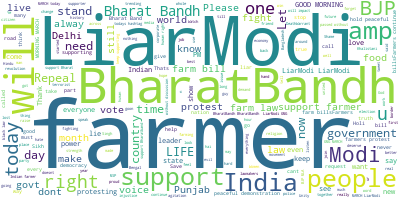

In [5]:
processed_tweets_df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

# join the words of the different tweets together into one string
long_string = ' '.join([text for text in processed_tweets_df['text_processed']])
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

# Topic Modelling

In [6]:
stop_words = stopwords.words('english')

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])
# create a dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create a corpus
texts = data_lemmatized

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

#Identify TF-IDF and use this as corpus
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

[['proud', 'moment', 'congratulation', 'ugraha', 'tikat', 'sir']]


In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [8]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

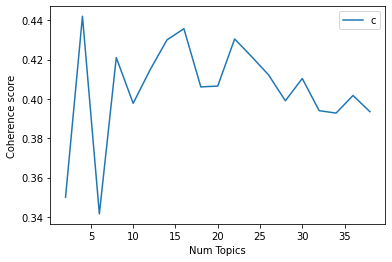

Num Topics = 2  has Coherence Value of 0.35
Num Topics = 4  has Coherence Value of 0.442
Num Topics = 6  has Coherence Value of 0.3415
Num Topics = 8  has Coherence Value of 0.421
Num Topics = 10  has Coherence Value of 0.3977
Num Topics = 12  has Coherence Value of 0.4148
Num Topics = 14  has Coherence Value of 0.43
Num Topics = 16  has Coherence Value of 0.4357
Num Topics = 18  has Coherence Value of 0.4061
Num Topics = 20  has Coherence Value of 0.4065
Num Topics = 22  has Coherence Value of 0.4304
Num Topics = 24  has Coherence Value of 0.4215
Num Topics = 26  has Coherence Value of 0.4122
Num Topics = 28  has Coherence Value of 0.399
Num Topics = 30  has Coherence Value of 0.4103
Num Topics = 32  has Coherence Value of 0.394
Num Topics = 34  has Coherence Value of 0.3928
Num Topics = 36  has Coherence Value of 0.4017
Num Topics = 38  has Coherence Value of 0.3935


In [9]:
# Show graph
start=2; limit=40; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

With the coherence score seems to keep increasing with the number of topics, it may make better sense to pick the model that gave the highest CV before flattening out or a major drop. In this case, we picked *k=16*

In [35]:
num_topics=22

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Select the model and print the topics
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(15,
  '0.047*"march" + 0.043*"brain" + 0.037*"people" + 0.035*"farmer" + '
  '0.029*"appreciate" + 0.016*"complete" + 0.016*"dance" + 0.016*"protester" + '
  '0.016*"strongly" + 0.016*"fake"'),
 (2,
  '0.049*"farmer" + 0.025*"protest" + 0.025*"awareness" + 0.020*"today" + '
  '0.020*"hurt" + 0.017*"khalistani" + 0.017*"transport" + 0.017*"india" + '
  '0.016*"thank" + 0.015*"go"'),
 (5,
  '0.065*"keep" + 0.063*"retweet" + 0.035*"love" + 0.030*"voice" + '
  '0.028*"value" + 0.026*"khela" + 0.026*"hobe" + 0.023*"farmer" + '
  '0.022*"tweet" + 0.017*"live"'),
 (3,
  '0.057*"bharat" + 0.053*"farmer" + 0.034*"stand" + 0.034*"force" + '
  '0.024*"bharatbandh" + 0.021*"close" + 0.021*"include" + 0.020*"fully" + '
  '0.019*"fighting" + 0.019*"peasant"'),
 (18,
  '0.290*"bharatbandh" + 0.082*"farmer" + 0.048*"support" + '
  '0.041*"bharat_bandh" + 0.036*"protest" + 0.022*"part" + '
  '0.019*"deathwarrant" + 0.016*"energy" + 0.015*"india" + 0.014*"update"'),
 (21,
  '0.055*"source" + 0.054*"bo

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### What is the Dominant topic and its percentage contribution in each tweet

In [26]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.3206,"bharatbandh, farmer, bharat_bandh, protest, modi, brain, appreciate, anti, bow, power",Proud moment for us congratulations ugraha ji and Tikat sir
1,1,2.0,0.9530,"bharatbandh, latest_development, deathwarrant, full, awareness, bhakts, energy, part, farmer, s",UPDATE Bapu Sukhdev Singh ji has been released from jail Bapu Ji with our legal team Panjaab Lawyers Senior Advocate Paramjeet Singh Full video from todays release
2,2,12.0,0.6789,"machine, bike, farmer, turn, leader, capitalist, cover, shake, tiger, mein",Found this one on Instragram page of SaffronStudios page
3,3,15.0,0.5569,"march, bharatbandh, thank, great, support, really, class, railway, hope, careful",The country is proud of Punjabis The people who are still protesting against your stupid laws Had people protested during Demonetization /GST and all these 7 years we wouldnt have seen this India Bravo Punjabis
4,4,1.0,0.6323,"update, bharatbandh, farmer, retweet, dangerous, petrol, haryana, share, totally, care",What a poetic message to Modi Gov
5,5,11.0,0.7669,"farmer, bill, farm, demonstration, hold_peaceful, repeal, symbol, shirt, continue, bus",Europe PLEASE can you advise if the World Health Organisation certified these products and brand and do they actually work?
6,6,11.0,0.6873,"farmer, bill, farm, demonstration, hold_peaceful, repeal, symbol, shirt, continue, bus",Action Reaction
7,7,6.0,0.7100,"farmer, bharatbandh, india, protest, terrorist, muslim, deathwarrant, leader, go, sikh",What farmers require is that the prices should be moderate and the markets steady and for this reason we need MSP
8,8,11.0,0.8122,"farmer, bill, farm, demonstration, hold_peaceful, repeal, symbol, shirt, continue, bus",kaur sohal4 Very beautifully written
9,9,4.0,0.6826,"inform, do, worker, bjp, nation, anymore, new, people, come, forget",Thanks everyone for follow me Special thanks to mare vere nu god bless you and all farmers supporters


### The most representative sentence for each topic

In [27]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9530,"support, farmer, food, role, totally, right, ahead, produce, spirit, energy",A Night of Forgiveness and Night of SuccessNew chapters of life are going to be written tonight Ya Allah please forgive and have mercy on usMay all our Duas be accepted and Sins forgiven A Blessed Mubarak
1,1.0,0.9531,"update, bharatbandh, farmer, retweet, dangerous, petrol, haryana, share, totally, care",Sooo adorable Kids of Punjab are like this only We all must Stay United for the Faith of these kids in Lets keep differences aside Tweet positive for Farmers BJP must take lesson from Abohar MLA incident
2,2.0,0.9608,"bharatbandh, latest_development, deathwarrant, full, awareness, bhakts, energy, part, farmer, s",Behind the scenes Our team makes sure we have various escape routes at all our tent cities which are clearly marked incase of an emergency making sure we are prepared at all timesThese images are from nearby our summer tent city in the woods at
3,3.0,0.9607,"farmer, bharatbandh, support, food, ban_evm, society, protest, country, bharat, educate",Owner Subhash Chandra had an event today in Hisar100s of Farmers gheroed the venue &amp forced Chandra to cancel itEvent organizers apologize to farmers for inviting himZee been peddling hate against farmers giving it back to
4,4.0,0.9623,"inform, do, worker, bjp, nation, anymore, new, people, come, forget",worrall Self defence is hardly lynching There needs to be an independent inquiry into red fort incident BJP mobs incited violence while police aided them Lynching minorities is what the BJP supporters do best ask u cant b/c they too had to flee India
5,5.0,0.9571,"bharatbandh, farmer, bharat_bandh, protest, modi, brain, appreciate, anti, bow, power",Watch the video properly thats farmer who has been assualted by BJP bhkts Not a MLA stop manipluating peopleAbhe tum TU apne desh ke farmers ke sath bi nhi krhee hu skteeeShame
6,6.0,0.9721,"farmer, bharatbandh, india, protest, terrorist, muslim, deathwarrant, leader, go, sikh",Ik BJP leader de shittar parade ton baad 100 lokan te case kar ditta jehre saade respected elders father and grandfather like figures nu ahna jailan ch ainne taseehe ditte gye nodeep nu sexually and physically exploit kita ohna da jawaab kaun duaga
7,7.0,0.9530,"bharatbandh, angry, support, farmer, need, deathwarrant, heart, trend, movement, morcha",How the RW in views Delhis leading universities as hubs of a gigantic foreign funded criminal run by a network of urban naxal jihadis using the constitution as a decoy to engineer violence
8,8.0,0.9375,"bharatbandh, source, shut, india, jumla, fighting, poor, march, legal, khela",What will you say about this Mr Morrison Isnt this human rights violation? in India More than 300 farmers have died in India They are still waiting for justice LiarModi
9,9.0,0.9592,"farmer, farm, repeal, share, strongly, work, band, gas, singh, proof",In Punjab farmers anger erupted over BJP leaders BJP MLA from Abohar Legislative Assembly Narang was beaten up in Malout by farmers tore clothes and molested The police rescued the MLA with great difficulty


### Frequency Distribution of Word Counts in Documents

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


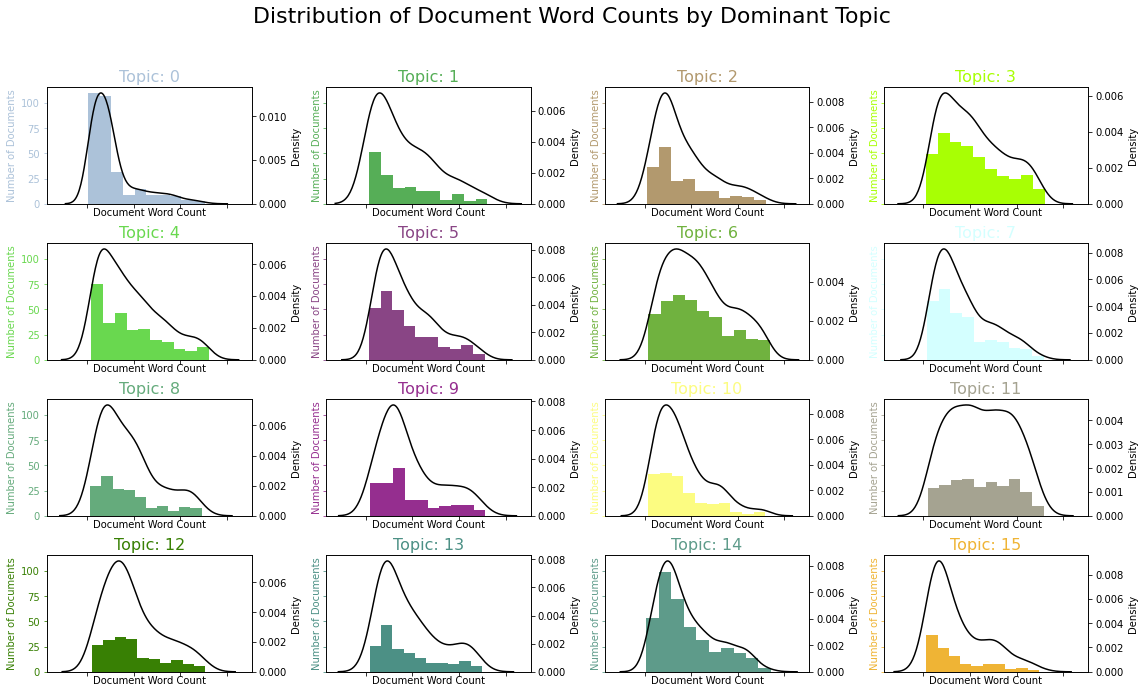

In [28]:
doc_lens = [len(d) for d in df_dominant_topic.Text]
cols = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

fig, axes = plt.subplots(6,4,figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):  
    if i<num_topics:
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
    else:
        ax.set_visible(False)

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


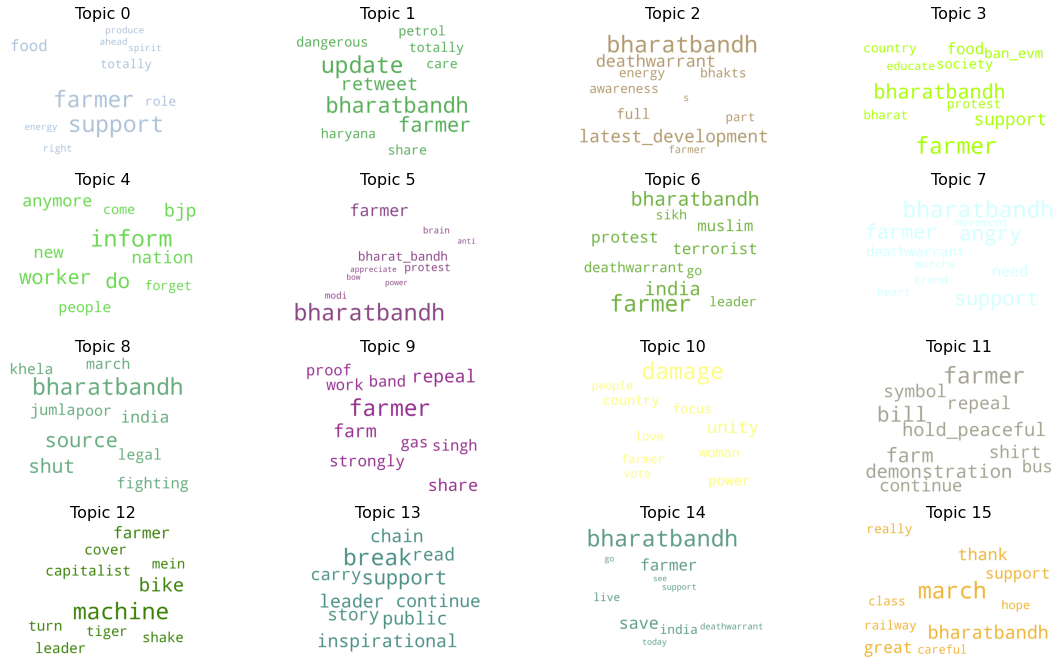

In [29]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=num_topics, num_words=10)

fig, axes = plt.subplots(6, 4, figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    else:
        ax.set_visible(False)


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-30-da26c95b3c90>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-30-da26c95b3c90>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-30-da26c95b3c90>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')

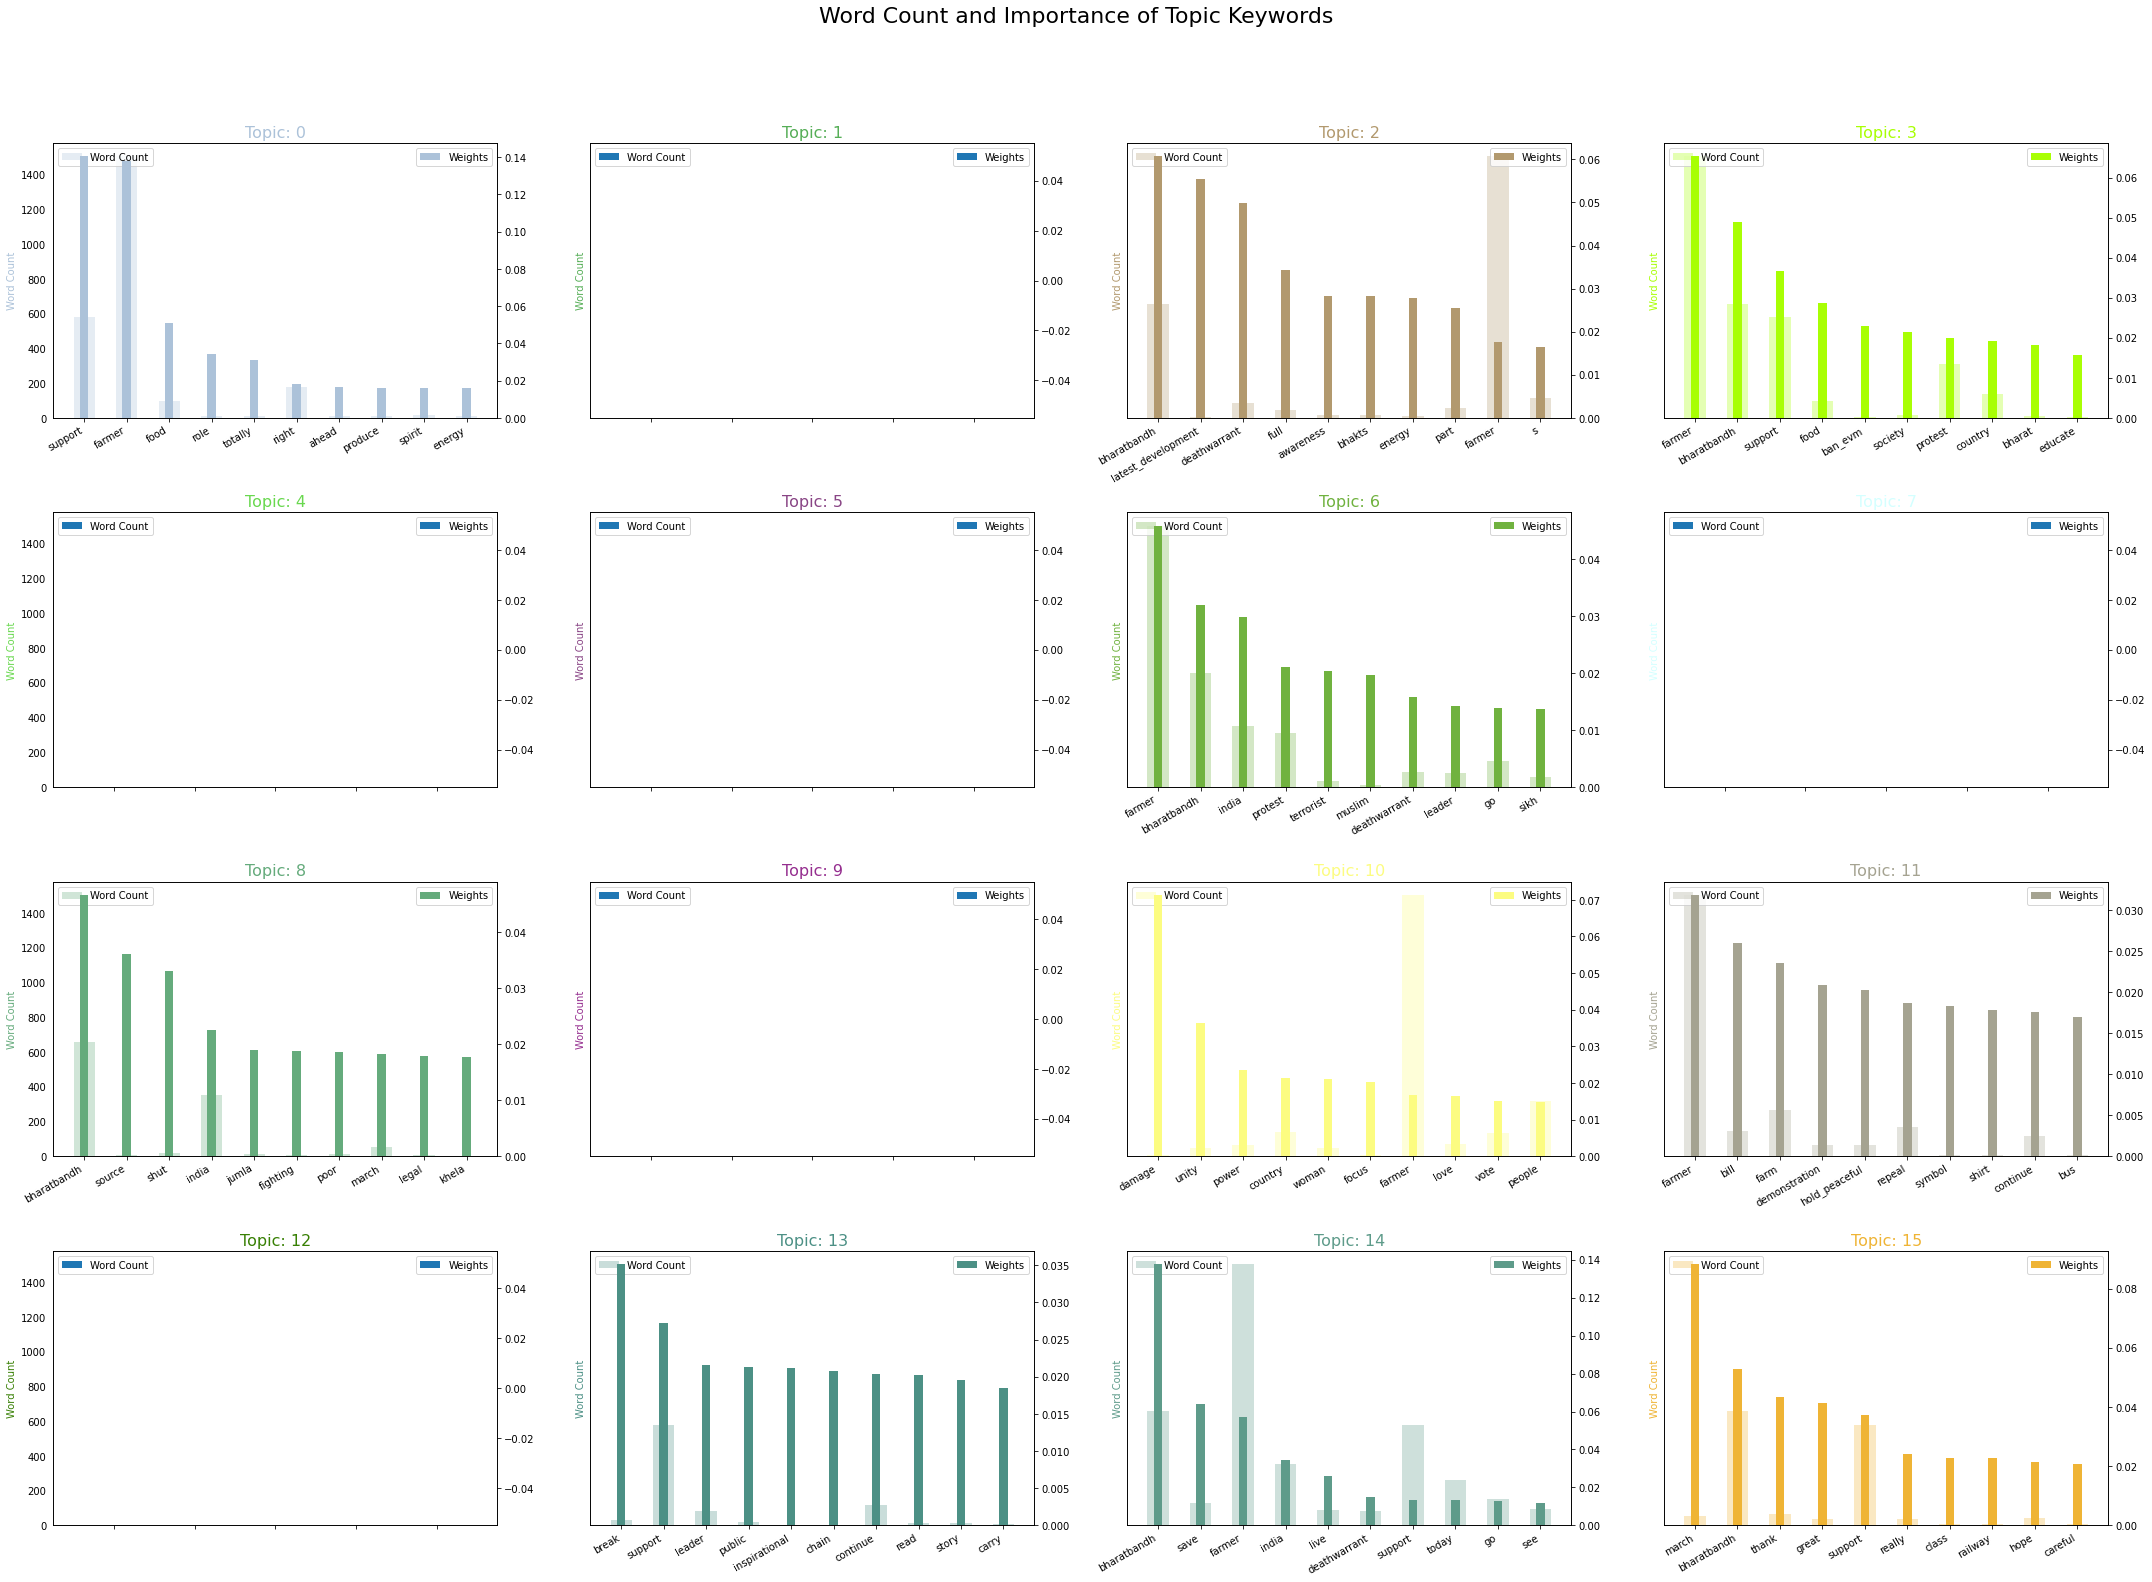

In [30]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(6, 4, figsize=(30,30), sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
#         ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    else:
        ax.set_visible(False)
        

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Compute Model Perplexity and Coherence Score

In [31]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -9.42165554415655

Coherence Score:  0.43566533535685015


### t-distributed stochastic neighbor embedding Clustering Chart

In [34]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    row = row_list[0] if optimal_model.per_word_topics else row_list 
    topic_weights.append([w for i, w in row])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(num_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=cols[topic_num])
show(plot)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3750 samples in 0.001s...
[t-SNE] Computed neighbors for 3750 samples in 0.525s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3750
[t-SNE] Computed conditional probabilities for sample 2000 / 3750
[t-SNE] Computed conditional probabilities for sample 3000 / 3750
[t-SNE] Computed conditional probabilities for sample 3750 / 3750
[t-SNE] Mean sigma: 0.000012
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.115208
[t-SNE] KL divergence after 1000 iterations: 0.499532


Loading BokehJS ...

In [33]:
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./topic-modelled-'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './topic-modelled-'+ str(num_topics) +'.html')

LDAvis_prepared

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.046447 -0.097300  1       1        11.244896
3      0.112614 -0.063294  2       1        10.003303
14     0.167483 -0.073425  3       1        8.720300 
11    -0.116777  0.000861  4       1        8.178668 
4     -0.082284 -0.116977  5       1        7.266274 
5      0.179630  0.043987  6       1        6.881943 
7      0.074571  0.076532  7       1        6.521447 
9     -0.141924  0.051463  8       1        5.579065 
12    -0.096172 -0.023480  9       1        4.999119 
10    -0.076588 -0.172352  10      1        4.948533 
2      0.042998  0.059329  11      1        4.716608 
8     -0.016612  0.073392  12      1        4.666785 
13    -0.106886  0.054260  13      1        4.591370 
0      0.002559  0.059067  14      1        4.521231 
1      0.033815 -0.001766  15      1        4.012114 
15    -0.022874  0.129701  16      1        3.148344 , topic_info=             Term         Freq        Total Category  logprob  loglift
1288  bharatbandh  1705.000000  1705.000000  Default  30.0000  30.0000
327   support      728.000000   728.000000   Default  29.0000  29.0000
55    farmer       1579.000000  1579.000000  Default  28.0000  28.0000
2685  angry        157.000000   157.000000   Default  27.0000  27.0000
1616  damage       126.000000   126.000000   Default  26.0000  26.0000
...      ...              ...          ...       ...      ...      ...
618   leader       5.497516     174.967763   Topic16 -5.3134  -0.0020 
350   live         4.763273     111.965969   Topic16 -5.4567   0.3010 
156   amp          4.415523     210.924755   Topic16 -5.5325  -0.4081 
76    do           4.381833     211.221034   Topic16 -5.5402  -0.4171 
456   pm           3.782099     89.998349    Topic16 -5.6874   0.2888 

[892 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
260   16     0.748539  aap      
176   12     0.042622  able     
176   15     0.895058  able     
1295  8      0.606390  abuse    
1295  9      0.303195  abuse    
...  ..           ...    ...    
189   4      0.169556  wrong    
189   15     0.508669  wrong    
1503  3      0.865714  yesterday
4080  11     0.743528  yudhveer 
2999  4      0.853267  zirakpur 

[2532 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 15, 12, 5, 6, 8, 10, 13, 11, 3, 9, 14, 1, 2, 16])

## Sentiment Analysis

-------------------- Need to be fixed -----------------------

In [ ]:
for i,grp in sent_topics_outdf_grpd[0]:
    print(grp)
    print()

In [ ]:

Topics = ['bjp', 'repeal', 'modi', 'farm laws']

for i in Topics:
    
    df = pd.read_csv('preprocessed_tweets.csv', quotechar='"', encoding='utf8')
    
    sub = i
    
    df['indexes'] = df['text_processed'].str.find(sub)
    
    # Get names of indexes which does not have the topic
    indexNames = df[ df['indexes'] == -1 ].index
    # Delete these row indexes from dataFrame
    df.drop(indexNames , inplace=True)
    #save for NER
    unique_tweets = df
    
    sid = SentimentIntensityAnalyzer()

    df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

    df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
    df['sentiment_type']=''
    df.loc[df.compound>0,'sentiment_type']='POSITIVE'
    df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
    df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
    
    fig, axes = plt.subplots(1, 1, figsize=(10,10), sharex=True, sharey=True)
   
    axes = df.sentiment_type.value_counts().plot.bar(title="sentiment analysis of "+i)
    
    print('\n' + i + 'Tweets \n')
    print(df.head())

## Named Entity Recognition

In [ ]:
import spacy
import en_core_web_trf

In [ ]:

Topics = ['bjp', 'repeal', 'modi', 'protest','farm laws']

for i in Topics:
    
    df = pd.read_csv('preprocessed_tweets.csv', quotechar='"', encoding='utf8')
    
    sub = i
    
    df['indexes'] = df['text_processed'].str.find(sub)
    
    # Get names of indexes which does not have the topic
    indexNames = df[ df['indexes'] == -1 ].index
    # Delete these row indexes from dataFrame
    df.drop(indexNames , inplace=True)
    #save for NER
    unique_tweets = df

unique_tweets_list = list(unique_tweets['text_processed'].values)

#Use a spacy model trained using our own dataset
nlp = spacy.load(r".\spacy_trained_model")


entities = list()

for tweet_text in unique_tweets_list:
  doc = nlp(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, ne.text,"--",tweet_text)
    entities.append(ne.text)

#print(entities)

